
# 2.0 Authenticating with Twitter's API


In [ ]:
!pip install Twython

In [2]:
from twython import Twython, TwythonError


## 2.1 Enter app info and get auth URL


In [3]:
# open the keys file
my_file = open("keys.txt", "r")

# read the raw data
content = my_file.read()

# split all lines by  newline character
API_KEY, API_SECRET_KEY = content.split("\n")

# close the file
my_file.close()

In [ ]:
twitter = Twython(API_KEY, API_SECRET_KEY)

authentication_tokens = twitter.get_authentication_tokens()
print(authentication_tokens['auth_url'])

In [5]:
# Replace the verifier with the pin number obtained with your web browser in the previous step
VERIFIER = '6138850'

twitter = Twython(API_KEY, API_SECRET_KEY,
                  authentication_tokens['oauth_token'],
                  authentication_tokens['oauth_token_secret'])

authorized_tokens = twitter.get_authorized_tokens(VERIFIER)


## 2.3 Use authorized tokens


In [6]:
twitter = Twython(API_KEY, API_SECRET_KEY,
                  authorized_tokens['oauth_token'],
                  authorized_tokens['oauth_token_secret'])

twitter.verify_credentials()

{'contributors_enabled': False,
 'created_at': 'Thu Aug 26 00:17:27 +0000 2010',
 'default_profile': False,
 'default_profile_image': False,
 'description': 'volto em breve',
 'entities': {'description': {'urls': []}},
 'favourites_count': 5070,
 'follow_request_sent': False,
 'followers_count': 171,
 'following': False,
 'friends_count': 89,
 'geo_enabled': False,
 'has_extended_profile': False,
 'id': 183031171,
 'id_str': '183031171',
 'is_translation_enabled': False,
 'is_translator': False,
 'lang': None,
 'listed_count': 1,
 'location': '',
 'name': 'julia',
 'needs_phone_verification': False,
 'notifications': False,
 'profile_background_color': '34BFBF',
 'profile_background_image_url': 'http://abs.twimg.com/images/themes/theme16/bg.gif',
 'profile_background_image_url_https': 'https://abs.twimg.com/images/themes/theme16/bg.gif',
 'profile_background_tile': False,
 'profile_banner_url': 'https://pbs.twimg.com/profile_banners/183031171/1602630101',
 'profile_image_url': 'http://

# 4.0 Using Twitter's search API to get tweets of interest



## 4.1 Get tweets matching a hashtag

We'll make use of the ability to search by hashtags:

## 4.2 Using a cursor to get more than 100 tweets from a search

We can only fetch up to 100 tweets at a time from a single search API call:

In [44]:
# even with count=1000, we still get at most 100 tweets
search_response = twitter.search(q='#renner', count=1000)
len(search_response['statuses'])

100

In order to get more tweets from a search, we can make use of a cursor:

In [45]:
import itertools

NUM_TWEETS_TO_FETCH = 1000

cursor = twitter.cursor(twitter.search, q='#renner', count=100, result_type='mixed')
search_tweets = list(itertools.islice(cursor, NUM_TWEETS_TO_FETCH))
len(search_tweets)

126

In [46]:
import pandas as pd

# Search tweets
dict_ = {'user': [], 'date': [], 'text': [], 'favorite_count': []}
for tweet in search_tweets:
    dict_['user'].append(tweet['user']['screen_name'])
    dict_['date'].append(tweet['created_at'])
    dict_['text'].append(tweet['text'])
    dict_['favorite_count'].append(tweet['favorite_count'])
# Structure data in a pandas DataFrame for easier manipulation
df = pd.DataFrame(dict_)

In [47]:
df.head()

,user,date,text,favorite_count
0,vemeconomizar,Tue Sep 14 18:06:55 +0000 2021,CUPOM DE DESCONTO RIACHUELO\n\nGanhe 10% off e...,0
1,vemeconomizar,Tue Sep 14 18:06:40 +0000 2021,CUPOM DE DESCONTO HERING!\n\nGanhe 10% off ext...,0
2,DominicanJonn,Tue Sep 14 16:57:14 +0000 2021,RT @DominicanJonn: #BundleofBrittany is alread...,0
3,vemeconomizar,Tue Sep 14 13:17:58 +0000 2021,CUPOM DE DESCONTO HERING!\n\nGanhe 10% off ext...,0
4,vemeconomizar,Tue Sep 14 11:14:51 +0000 2021,CUPOM DE DESCONTO RIACHUELO\n\nGanhe 10% off e...,0


In [48]:
df.shape

(126, 4)

In [49]:
twitter.get_application_rate_limit_status()['resources']['search']

{'/search/tweets': {'limit': 180, 'remaining': 176, 'reset': 1631649731}}

# 6.0 Twitter retweet network



## 6.1 Get some tweets

In [57]:
import itertools


NUM_TWEETS_TO_FETCH =5000

cursor01 = twitter.cursor(twitter.search, q='lojas renner', count=100, result_type='mixed')
cursor02 = twitter.cursor(twitter.search, q='na renner', count=100, result_type='mixed')
cursor03 = twitter.cursor(twitter.search, q='da renner', count=100, result_type='mixed')
somatorio = [*cursor01, *cursor02, *cursor03]
search_tweets = list(itertools.islice(somatorio, NUM_TWEETS_TO_FETCH))

len(search_tweets)

6355

## 6.2 Filter retweets


In [58]:
retweets = []
for tweet in search_tweets:
    if 'retweeted_status' in tweet:
        retweets.append(tweet)
len(retweets)

1329

In [59]:
import pandas as pd

# Search tweets
dict_ = {'user': [], 'date': [], 'text': [], 'favorite_count': []}
for tweet in search_tweets:
    dict_['user'].append(tweet['user']['screen_name'])
    dict_['date'].append(tweet['created_at'])
    dict_['text'].append(tweet['text'])
    dict_['favorite_count'].append(tweet['favorite_count'])
# Structure data in a pandas DataFrame for easier manipulation
df = pd.DataFrame(dict_)

In [60]:
df.head()

,user,date,text,favorite_count
0,Lojas_Renner,Tue Sep 14 01:31:02 +0000 2021,será que fez no cartão renner? \nespero que si...,399
1,Wallo0ry,Tue Sep 14 22:04:17 +0000 2021,RT @swtyoons: Ariana arrasando no red carpet c...,0
2,_dinhow,Tue Sep 14 21:47:35 +0000 2021,@americanascom @marigraciolli Nesse caso seria...,0
3,enricokkkw,Tue Sep 14 21:44:54 +0000 2021,@_ricardoscs_ @Lojas_Renner @Lojas_Renner oi r...,1
4,camsscb,Tue Sep 14 21:44:37 +0000 2021,RT @swtyoons: Ariana arrasando no red carpet c...,0


In [61]:
df.shape

(6355, 4)

In [62]:
df.to_csv("renner.csv")

## 6.3 Create DiGraph


In [63]:
import networkx as nx

D = nx.DiGraph()

for retweet in retweets:
    retweeted_status = retweet['retweeted_status']
    retweeted_sn = retweeted_status['user']['screen_name']
    retweeter_sn = retweet['user']['screen_name']
    
    # Edge direction: retweeted_sn -> retweeter_sn
    if D.has_edge(retweeted_sn, retweeter_sn):
        D.edges[retweeted_sn, retweeter_sn]['weight'] += 1
    else:
        D.add_edge(retweeted_sn, retweeter_sn, weight=1)

## 6.4 Analyze graph



### 6.4.1 Most retweeted user


In [64]:
max(D.nodes, key=D.out_degree)

'pavliique'

In [65]:
from operator import itemgetter

sorted(D.out_degree(), key=itemgetter(1), reverse=True)[:5]

[('pavliique', 114),
 ('wxvivi', 77),
 ('legendarylovers', 72),
 ('RandonadmM', 70),
 ('aresnoert', 54)]

In [66]:
D.out_degree()

OutDegreeView({'swtyoons': 25, 'Wallo0ry': 0, 'camsscb': 0, '_ziur1': 0, 'Felipe_xcmrg': 0, 'brunojesusjr': 0, '_jdls02': 0, 'laripaiivva': 0, 'Oliverxulia': 0, 'TaurinoDeboista': 1, 'RecifeBot': 0, 'sanluhh': 0, 'gugahummel': 0, 'R4fuds': 0, 'euhenriique': 0, 'gus7a_v0': 0, 'laviniabast': 0, 'renatopeixotoo': 0, 'jisungcolors_': 1, 'Pinkgir56282753': 0, 'Myfu_Dendo': 0, 'JovemDavizinho': 0, 'beatrizz_ellen': 0, '_annagpj': 0, 'MatheusRonndao': 1, 'PauloAndersonn': 0, 'Isa_amorim19': 0, 'Tatiapplehead': 1, 'JampaRobo': 0, 'eujuliovictor': 3, 'strealitas': 0, 'sophi_barraa': 0, 'xelo_dotzjv': 0, 'cavassan1': 0, 'ninilsd': 0, 'jisooturtle0': 0, 'nicososz': 1, 'eternalsdune': 0, 'dicapriopugh': 2, 'mi__motta': 0, 'vhstucky': 0, 'marcelleoliver': 1, 'wheeinice': 0, 'BrandFinance': 3, 'NanVazy': 0, 'dfndr_br': 1, 'emilio_simoni': 0, '_JosePerales': 0, 'marlosandrey': 1, 'Piixulinha': 1, 'imxrcur': 0, 'jeansantospbr': 2, 'omuriIo': 0, 'aquelaborgui': 2, 'millesilva007': 0, 'JuhlianaNelli': 0

In [67]:
sorted(D.out_degree(weight='weight'), key=itemgetter(1), reverse=True)[:5]

[('pavliique', 114),
 ('wxvivi', 77),
 ('legendarylovers', 72),
 ('RandonadmM', 70),
 ('aresnoert', 54)]


### 6.4.2 Anomaly detection


In [33]:
sorted(D.in_degree(weight='weight'), key=itemgetter(1), reverse=True)[:5]

[('Renner_SSouza', 86),
 ('Renner_Souza_', 29),
 ('o_renner', 6),
 ('Renner_AfD', 5),
 ('bot_cockroach', 4)]

### 6.4.3 Connectivity


In [34]:
nx.is_weakly_connected(D)

False

In [35]:
nx.number_weakly_connected_components(D)

209

### 6.4.4 Drawing


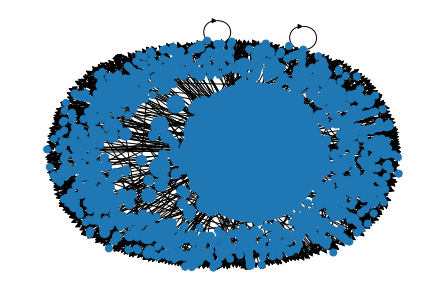

In [79]:
node_sizes = [D.out_degree(n, weight='weight') * 50 for n in D.nodes]

%matplotlib inline
nx.draw(D, node_size=node_sizes)
nx.write_graphml(D, "renner_rtt.graphml")

# 7.0 Twitter mention network



## 7.1 Get some tweets

In [68]:
import itertools

NUM_TWEETS_TO_FETCH = 5000

cursor01 = twitter.cursor(twitter.search, q='lojas renner', count=100, result_type='mixed')
cursor02 = twitter.cursor(twitter.search, q='na renner', count=100, result_type='mixed')
cursor03 = twitter.cursor(twitter.search, q='da renner', count=100, result_type='mixed')
somatorio = [*cursor01, *cursor02, *cursor03]
search_tweets = list(itertools.islice(somatorio, NUM_TWEETS_TO_FETCH))

len(search_tweets)

5000

In [70]:
search_tweets[0]

{'contributors': None,
 'coordinates': None,
 'created_at': 'Tue Sep 14 01:31:02 +0000 2021',
 'entities': {'hashtags': [{'indices': [47, 59], 'text': 'MetGala2021'}],
  'symbols': [],
  'urls': [{'display_url': 'twitter.com/RandonadmM/sta…',
    'expanded_url': 'https://twitter.com/RandonadmM/status/1437549451598569473',
    'indices': [60, 83],
    'url': 'https://t.co/16aPe1ftUe'}],
  'user_mentions': []},
 'favorite_count': 399,
 'favorited': False,
 'geo': None,
 'id': 1437589674336432130,
 'id_str': '1437589674336432130',
 'in_reply_to_screen_name': None,
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'is_quote_status': True,
 'lang': 'pt',
 'metadata': {'iso_language_code': 'pt', 'result_type': 'popular'},
 'place': None,
 'possibly_sensitive': False,
 'quoted_status': {'contributors': None,
  'coordinates': None,
  'created_at': 'Mon Sep 13 22:51:12 +0000 2021',
  'entities': {'hashtags': [],


In [71]:
import networkx as nx

D = nx.DiGraph()

for tweet in search_tweets:
    tweet_sn = tweet['user']['screen_name']
    for user_mention in tweet['entities']['user_mentions']:
        mentioned_sn = user_mention['screen_name']
        
        my_edge = (tweet_sn, mentioned_sn)
        if D.has_edge(*my_edge):
            D.edges[my_edge]['weight'] += 1
        else:
            D.add_edge(*my_edge, weight=1)

## 7.3 Analyze graph



### 7.3.1 Most  popular users


In [72]:
max(D.nodes, key=D.in_degree)

'Lojas_Renner'

In [73]:
from operator import itemgetter

sorted(D.in_degree(), key=itemgetter(1), reverse=True)[:5]

[('Lojas_Renner', 397),
 ('pavliique', 114),
 ('wxvivi', 78),
 ('legendarylovers', 72),
 ('RandonadmM', 71)]

In [74]:
sorted(D.in_degree(weight='weight'), key=itemgetter(1), reverse=True)[:5]

[('Lojas_Renner', 683),
 ('pavliique', 114),
 ('wxvivi', 78),
 ('legendarylovers', 72),
 ('RandonadmM', 71)]


### 7.3.2 Conversation drivers


In [75]:
sorted(D.out_degree(weight='weight'), key=itemgetter(1), reverse=True)[:5]

[('Lojas_Renner', 390),
 ('Renner_SSouza', 80),
 ('johnnyjpmendes', 72),
 ('Renner_AfD', 33),
 ('AnaGolitz', 22)]

### 7.3.3 Connectivity


In [76]:
nx.is_weakly_connected(D)

False

In [77]:
nx.number_weakly_connected_components(D)

833

### 7.3.4 Drawing


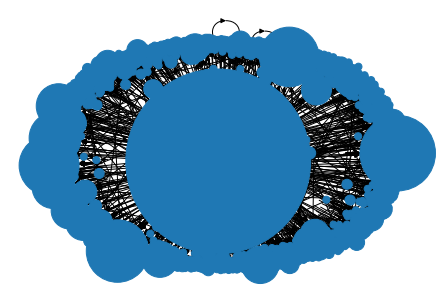

In [78]:
node_sizes = [D.in_degree(n, weight='weight') * 50 for n in D.nodes]

%matplotlib inline
nx.draw(D, node_size=node_sizes)
nx.write_graphml(D, "renner_men.graphml")